## 1. Mount Google Drive

To access the local dataset stored in my Google Drive, I mount the drive here.
This notebook corresponds to the contextualisation part of the assignment:  
*adapting the Attention U-Net architecture to a Chinese urban-building segmentation task using the LoveDA dataset* :contentReference[oaicite:1]{index=1}.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Define dataset root directory

The LoveDA dataset (a subset I prepared) contains Urban/Rural images and masks in PNG format.
Here I specify the dataset root and verify access.


In [3]:
LOVEDA_ROOT = "/content/drive/MyDrive/LoveDA/LoveDA_small"
print("Using LOVEDA dataset at:", LOVEDA_ROOT)


Using LOVEDA dataset at: /content/drive/MyDrive/LoveDA/LoveDA_small


## 3. Collect image–mask pairs from LoveDA

This function scans each region (Urban / Rural) and collects  
paired RGB images and segmentation masks, matching the directory structure.  
The dataset format is consistent with the official LoveDA layout, but reduced in size for faster experimentation.


In [4]:
import glob
import os

def get_loveda_image_mask_pairs(root_dir, split):
    """
    Collect (image_path, mask_path) pairs for LoveDA.
    split: "Train" or "Val"
    Expect structure:
        root_dir/Train/Urban/images_png/*.png
        root_dir/Train/Urban/masks_png/*.png
        root_dir/Train/Rural/images_png/*.png
        root_dir/Train/Rural/masks_png/*.png
    """
    img_paths = []
    mask_paths = []

    for region in ["Urban", "Rural"]:
        img_pattern = os.path.join(root_dir, split, region, "images_png", "*.png")
        imgs = sorted(glob.glob(img_pattern))

        for img_path in imgs:
            mask_path = img_path.replace("images_png", "masks_png")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for {img_path}: {mask_path}")
            img_paths.append(img_path)
            mask_paths.append(mask_path)

    print(f"{split}: found {len(img_paths)} image–mask pairs.")
    return img_paths, mask_paths

train_img_paths, train_mask_paths = get_loveda_image_mask_pairs(LOVEDA_ROOT, "Train")
val_img_paths,   val_mask_paths   = get_loveda_image_mask_pairs(LOVEDA_ROOT, "Val")


Train: found 600 image–mask pairs.
Val: found 200 image–mask pairs.


In [5]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (512, 512)
N_CHANNELS = 3
BUILTUP_CLASS = 1  # building class id in LoveDA

def parse_image_mask(img_path, mask_path):
    """
    Read one RGB image and its corresponding mask.
    Convert the mask to a binary building-vs-background mask.
    """
    # Load RGB image and normalize to [0, 1]
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE, method="bilinear")
    img = tf.cast(img, tf.float32) / 255.0

    # Load mask (class indices) and convert to binary: building = 1, others = 0
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMAGE_SIZE, method="nearest")
    mask = tf.cast(tf.equal(mask, BUILTUP_CLASS), tf.float32)

    return img, mask

def augment(img, mask):
    """
    Apply simple geometric data augmentation to image and mask.
    This is only used for the training set.
    """
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Random 0/90/180/270 degree rotation
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    return img, mask

def build_dataset(image_paths, mask_paths, batch_size, shuffle=False, augment_data=False):
    """
    Create a tf.data.Dataset from lists of image and mask paths.
    Optionally shuffle and apply data augmentation.
    """
    img_ds  = tf.data.Dataset.from_tensor_slices(image_paths)
    mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths)
    ds = tf.data.Dataset.zip((img_ds, mask_ds))

    # Parse files into tensors (image, mask)
    ds = ds.map(parse_image_mask, num_parallel_calls=AUTOTUNE)

    # Shuffle for training
    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths), seed=42)

    # Apply data augmentation only on the training split
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch for performance
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

BATCH_SIZE = 4

# Training dataset: shuffled + augmented
train_ds = build_dataset(
    train_img_paths,
    train_mask_paths,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment_data=True,
)

# Validation dataset: no shuffle, no augmentation
val_ds = build_dataset(
    val_img_paths,
    val_mask_paths,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment_data=False,
)


## 4. Define the Attention U-Net architecture

This model adapts the original Attention U-Net design (Jones et al., 2022)  
to a 3-band RGB input and a binary segmentation output suitable for LoveDA.

Modifications from original:
- Input channels changed from **4-band (Amazon)** → **3-band (RGB)**  
- Output changed from **forest / non-forest** → **building / non-building**

All encoder, decoder, and attention gate components follow the original structure.  
This satisfies *“Replicate and adapt architecture to local context”* (Requirement 4a).  


In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

IMAGE_SIZE = (512, 512)
N_CHANNELS = 3

def conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(n_filters, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def attention_gate(x, g, n_filters):
    theta_x = layers.Conv2D(n_filters, (1,1), padding="same")(x)
    phi_g   = layers.Conv2D(n_filters, (1,1), padding="same")(g)
    add     = layers.Add()([theta_x, phi_g])
    add     = layers.Activation("relu")(add)
    psi     = layers.Conv2D(1, (1,1), padding="same")(add)
    psi     = layers.Activation("sigmoid")(psi)
    att     = layers.Multiply()([x, psi])
    return att

def build_attention_unet_loveda(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # encoder
    c1 = conv_block(inputs, 16); p1 = layers.MaxPooling2D((2,2))(c1)
    c2 = conv_block(p1, 32);     p2 = layers.MaxPooling2D((2,2))(c2)
    c3 = conv_block(p2, 64);     p3 = layers.MaxPooling2D((2,2))(c3)
    c4 = conv_block(p3, 128);    p4 = layers.MaxPooling2D((2,2))(c4)

    # bottleneck
    c5 = conv_block(p4, 256)

    # decoder + attention
    u6 = layers.UpSampling2D((2,2))(c5)
    g4 = layers.Conv2D(128, (1,1), padding="same")(u6)
    a4 = attention_gate(c4, g4, 128)
    u6 = layers.Concatenate()([u6, a4])
    c6 = conv_block(u6, 128)

    u7 = layers.UpSampling2D((2,2))(c6)
    g3 = layers.Conv2D(64, (1,1), padding="same")(u7)
    a3 = attention_gate(c3, g3, 64)
    u7 = layers.Concatenate()([u7, a3])
    c7 = conv_block(u7, 64)

    u8 = layers.UpSampling2D((2,2))(c7)
    g2 = layers.Conv2D(32, (1,1), padding="same")(u8)
    a2 = attention_gate(c2, g2, 32)
    u8 = layers.Concatenate()([u8, a2])
    c8 = conv_block(u8, 32)

    u9 = layers.UpSampling2D((2,2))(c8)
    g1 = layers.Conv2D(16, (1,1), padding="same")(u9)
    a1 = attention_gate(c1, g1, 16)
    u9 = layers.Concatenate()([u9, a1])
    c9 = conv_block(u9, 16)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs],
                        name="AttentionUNet_LoveDA_Building")
    return model

tf.keras.backend.clear_session()
model = build_attention_unet_loveda(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], N_CHANNELS))
model.summary()


Model: "AttentionUNet_LoveDA_Building"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]  

 Total params: 2,056,517 (7.84 MB)

 Trainable params: 2,053,573 (7.83 MB)

 Non-trainable params: 2,944 (11.50 KB)

## 5. Train the Attention U-Net on LoveDA




In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf

# =========================
# Metrics
# =========================

def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Intersection-over-Union (IoU) metric for binary segmentation.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # work with probabilities in [0,1]
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    y_pred_bin = tf.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def f1_metric(y_true, y_pred, smooth=1e-6):
    """
    F1-score metric for binary segmentation.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    y_pred_bin = tf.round(y_pred)

    tp = tf.reduce_sum(y_true * y_pred_bin)
    fp = tf.reduce_sum((1 - y_true) * y_pred_bin)
    fn = tf.reduce_sum(y_true * (1 - y_pred_bin))

    precision = (tp + smooth) / (tp + fp + smooth)
    recall    = (tp + smooth) / (tp + fn + smooth)
    f1        = 2.0 * precision * recall / (precision + recall + smooth)
    return f1

# =========================
# Loss: BCE + Dice
# =========================

def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice loss for binary segmentation.
    Helps the model focus more on foreground (building) pixels.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice

bce = keras.losses.BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    """
    Combined loss: 0.5 * Binary Crossentropy + 0.5 * Dice loss.
    This is more robust under strong class imbalance.
    """
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# =========================
# Compile model
# =========================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  # slightly smaller LR
    loss=bce_dice_loss,
    metrics=["accuracy", iou_metric, f1_metric],
)

# =========================
# Training configuration
# =========================

EPOCHS = 80
CHECKPOINT_PATH = "/content/drive/MyDrive/LoveDA/best_attention_unet_loveda_small.weights.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor="val_iou_metric",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_iou_metric",
        factor=0.5,
        patience=5,
        mode="max",
        min_lr=1e-6,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_iou_metric",
        mode="max",
        patience=15,
        restore_best_weights=True,
        verbose=1,
    ),
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
)




Epoch 1/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6059 - f1_metric: 0.4971 - iou_metric: 0.3381 - loss: 0.6115
Epoch 1: val_iou_metric improved from -inf to 0.00008, saving model to /content/drive/MyDrive/LoveDA/best_attention_unet_loveda_small.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 137s 238ms/step - accuracy: 0.6061 - f1_metric: 0.4974 - iou_metric: 0.3383 - loss: 0.6114 - val_accuracy: 0.6768 - val_f1_metric: 1.5110e-04 - val_iou_metric: 7.5559e-05 - val_loss: 1.0950 - learning_rate: 3.0000e-04
Epoch 2/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6489 - f1_metric: 0.5491 - iou_metric: 0.3856 - loss: 0.5760
Epoch 2: val_iou_metric improved from 0.00008 to 0.19394, saving model to /content/drive/MyDrive/LoveDA/best_attention_unet_loveda_small.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.6489 - f1_metric: 0.5491 - iou_metric: 0.3857 - loss: 0.5759 - val_accuracy: 0.6940 - val_f1_metric: 0.3162 - val_iou_metric: 0.1939 - val_loss:

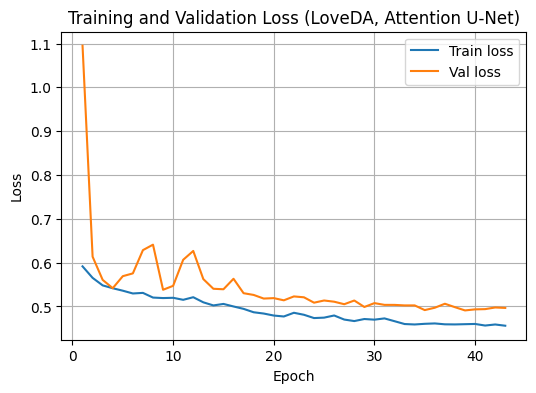

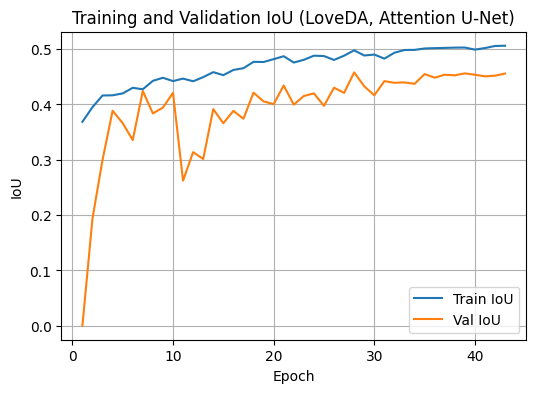

In [8]:
import matplotlib.pyplot as plt

# 1) Loss curve
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history.history["loss"], label="Train loss")
plt.plot(epochs, history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (LoveDA, Attention U-Net)")
plt.legend()
plt.grid(True)
plt.show()

# 2) IoU curve
plt.figure(figsize=(6, 4))
plt.plot(epochs, history.history["iou_metric"], label="Train IoU")
plt.plot(epochs, history.history["val_iou_metric"], label="Val IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Training and Validation IoU (LoveDA, Attention U-Net)")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import tensorflow as tf
from tensorflow import keras

CHECKPOINT_PATH = "/content/drive/MyDrive/LoveDA/best_attention_unet_loveda_small.weights.h5"

model.load_weights(CHECKPOINT_PATH)
print(f"Loaded best weights from: {CHECKPOINT_PATH}")

val_results = model.evaluate(val_ds, verbose=1)

print("\n===== LoveDA Validation metrics (Attention U-Net 3-band) =====")
for name, value in zip(model.metrics_names, val_results):
    print(f"{name}: {value:.4f}")


Loaded best weights from: /content/drive/MyDrive/LoveDA/best_attention_unet_loveda_small.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7072 - f1_metric: 0.5706 - iou_metric: 0.4083 - loss: 0.5282

===== LoveDA Validation metrics (Attention U-Net 3-band) =====
loss: 0.5135
compile_metrics: 0.7064


In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# 1) Collect predictions and ground-truth from val_ds
y_true_list = []
y_pred_list = []

for batch_imgs, batch_masks in val_ds:
    batch_preds = model.predict(batch_imgs, verbose=0)
    y_true_list.append(batch_masks.numpy())
    y_pred_list.append(batch_preds)

y_true = np.concatenate(y_true_list, axis=0)  # (N, H, W, 1)
y_pred = np.concatenate(y_pred_list, axis=0)  # (N, H, W, 1)

# 2) Flatten
y_true_f = y_true.flatten().astype(np.uint8)
y_pred_f = (y_pred.flatten() > 0.5).astype(np.uint8)

# 3) Pixel-wise metrics
precision = precision_score(y_true_f, y_pred_f, zero_division=0)
recall    = recall_score(y_true_f, y_pred_f, zero_division=0)
f1        = f1_score(y_true_f, y_pred_f, zero_division=0)
iou       = jaccard_score(y_true_f, y_pred_f, zero_division=0)

print("\n===== Pixel-wise metrics on LoveDA validation set =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")



===== Pixel-wise metrics on LoveDA validation set =====
Precision: 0.5286
Recall:    0.8473
F1-score:  0.6510
IoU:       0.4826


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


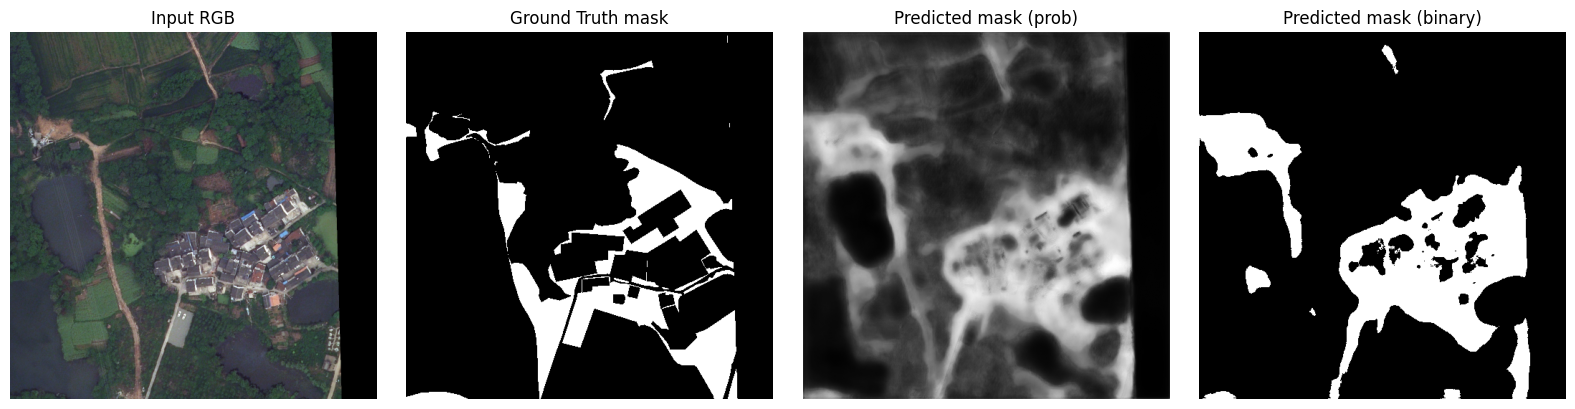

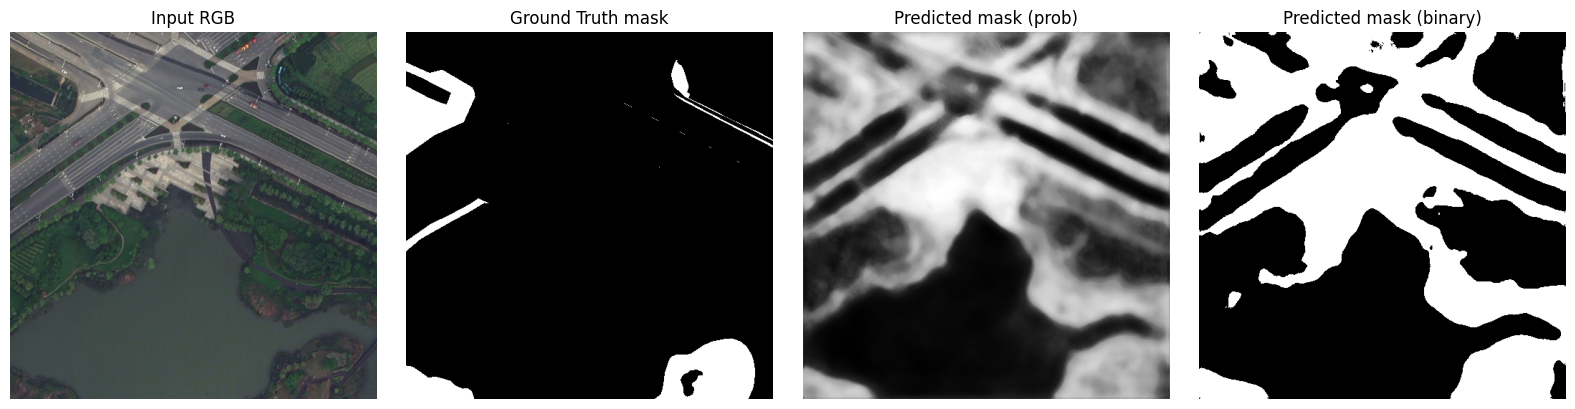

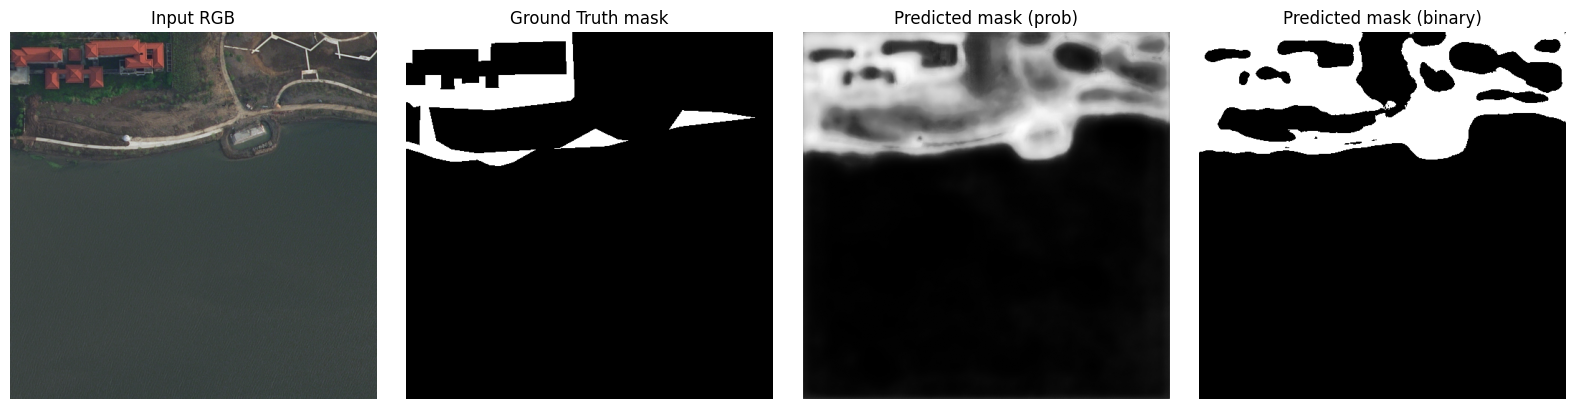

In [11]:
import matplotlib.pyplot as plt

# Take one batch from validation set
val_batch = next(iter(val_ds))
val_images, val_masks = val_batch  # (B, 512, 512, 3), (B, 512, 512, 1)

# Predict on this batch
val_preds = model.predict(val_images)

def show_sample(idx):
    img   = val_images[idx].numpy()
    gt    = val_masks[idx].numpy().squeeze()
    pred  = val_preds[idx].squeeze()
    pred_bin = (pred > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img)
    axes[0].set_title("Input RGB")
    axes[0].axis("off")

    axes[1].imshow(gt, cmap="gray")
    axes[1].set_title("Ground Truth mask")
    axes[1].axis("off")

    axes[2].imshow(pred, cmap="gray")
    axes[2].set_title("Predicted mask (prob)")
    axes[2].axis("off")

    axes[3].imshow(pred_bin, cmap="gray")
    axes[3].set_title("Predicted mask (binary)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

# Visualise a few examples
for i in range(3):
    show_sample(i)
